# Long-Term Indexer Returns

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_theme(); 
sns.set(rc={'figure.figsize':(11.7,8.27)})
import matplotlib.pyplot as plt
rng = np.random.default_rng()
import wrds

# from fredapi import Fred
# fred = Fred(api_key='37eb22bada238c97f282715480e7d897')

In [5]:
db = wrds.Connection(wrds_username='bgreen41')

Loading library list...
Done


In [11]:
def inspect_df(df:pd.DataFrame):
    """Print the df.head() & df.shape & df.describe()"""
    print(df.shape)
    display(df.head())
    display(df.describe())

In [21]:
# Load SP 500 Daily Returns
query_string = f"""SELECT * from crsp.dsp500 order by caldt"""
data_sp = db.raw_sql(query_string)

In [15]:
inspect_df(data_sp)

(25360, 11)


,caldt,vwretd,vwretx,ewretd,ewretx,totval,totcnt,usdval,usdcnt,spindx,sprtrn
0,1925-12-31,NaN,NaN,NaN,NaN,15236829.5,89.0,NaN,NaN,NaN,NaN
1,1926-01-02,0.004297,0.004297,0.002941,0.002941,15319686.5,89.0,15236829.5,79.0,NaN,NaN
2,1926-01-04,-0.001357,-0.001357,0.001036,0.001036,15298901.2,89.0,15319686.5,80.0,NaN,NaN
3,1926-01-05,-0.004603,-0.004653,-0.005856,-0.006063,15227711.5,89.0,15298901.2,80.0,NaN,NaN
4,1926-01-06,0.000537,0.000537,0.000888,0.000888,15235889.2,89.0,15227711.5,80.0,NaN,NaN


,vwretd,vwretx,ewretd,ewretx,totval,totcnt,usdval,usdcnt,spindx,sprtrn
count,25359.000000,25359.000000,25359.000000,25359.000000,2.536000e+04,25360.000000,2.535900e+04,25359.000000,15041.000000,15040.000000
mean,0.000434,0.000292,0.000556,0.000423,4.291494e+09,355.202957,4.290122e+09,354.659884,840.920251,0.000346
std,0.011437,0.011440,0.012532,0.012532,7.472955e+09,196.356625,7.469925e+09,196.523176,949.739123,0.010312
min,-0.194583,-0.194660,-0.184222,-0.184269,6.105188e+06,89.000000,6.105188e+06,78.000000,53.490000,-0.204669
25%,-0.004221,-0.004359,-0.004154,-0.004298,2.560060e+07,90.000000,2.558167e+07,90.000000,103.930000,-0.004248
50%,0.000669,0.000538,0.000881,0.000729,4.894768e+08,500.000000,4.894581e+08,499.000000,413.510000,0.000477
75%,0.005380,0.005240,0.005546,0.005423,5.703440e+09,500.000000,5.698018e+09,500.000000,1278.940000,0.005173
max,0.168133,0.167209,0.206157,0.205799,4.235657e+10,508.000000,4.235657e+10,508.000000,4796.560000,0.115800


In [26]:

df_sp = data_sp.dropna().copy() # For some reason, there are NAs in the beginning for S&P index
df_sp['date'] = pd.to_datetime(df_sp.caldt)
df_sp = df_sp[['date','totcnt','spindx','sprtrn']].copy()

# Make data columns
df_sp['year'] = df_sp.date.dt.year
df_sp['month'] = df_sp.date.dt.month
df_sp['day'] = df_sp.date.dt.day


df_sp['price_return'] = df_sp.spindx.pct_change()
df_sp = df_sp.dropna()

df_sp.head()

,date,totcnt,spindx,sprtrn,year,month,day,price_return
10321,1962-07-05,500.0,56.81,0.005665,1962,7,5,0.005665
10322,1962-07-06,500.0,56.17,-0.011266,1962,7,6,-0.011266
10323,1962-07-09,500.0,56.55,0.006765,1962,7,9,0.006765
10324,1962-07-10,500.0,57.20,0.011494,1962,7,10,0.011494
10325,1962-07-11,500.0,57.73,0.009266,1962,7,11,0.009266


In [33]:
df_sp.to_excel('data.xlsx')

In [28]:
from typing import Iterable, Union

In [30]:
def cumulative_return(returns:Iterable[float]) -> float:
    return np.prod(1+np.array(returns)) - 1

In [34]:
df_monthly = pd.pivot_table(df_sp,values='sprtrn',index=['year','month'],aggfunc=cumulative_return)
df_monthly

sprtrn
year month          
1962 7      0.030802
     8      0.015284
     9     -0.048207
     10     0.004443
     11     0.101557
...              ...
2021 11    -0.008334
     12     0.043613
2022 1     -0.052585
     2     -0.031361
     3      0.035773

[717 rows x 1 columns]

Test the Strategy:

Every Single Month buy the index. Do nothing for 10 years. What is the return?

In [69]:
df_monthly.reset_index()

,year,month,sprtrn
0,1962,7,0.030802
1,1962,8,0.015284
2,1962,9,-0.048207
3,1962,10,0.004443
4,1962,11,0.101557
...,...,...,...
712,2021,11,-0.008334
713,2021,12,0.043613
714,2022,1,-0.052585
715,2022,2,-0.031361


Below cell will take about 90 seconds to run.

In [118]:
MAX_HOLDING_PERIOD_MONTHS = 12*50  # 50 Years 
col_index = range(1,MAX_HOLDING_PERIOD_MONTHS+1)

df_results = pd.DataFrame(index=df_monthly.index, columns=col_index)

for holding_months in col_index:
    # holding_months = holding_period[1]

    for i in range(len(df_results)-holding_months+1):
        # Calculate return for next holding period
        # print(i,holding_months)
        df_results.iloc[i,holding_months-1] = cumulative_return(df_monthly.iloc[i:(i+holding_months),0])

df_results = df_results.astype(float)
df_results

1         2         3         4         5         6    \
year month                                                               
1962 7      0.030802  0.046557 -0.003894  0.000531  0.102142  0.117012   
     8      0.015284  -0.03366 -0.029366  0.069208  0.083634  0.136871   
     9     -0.048207 -0.043978  0.053112  0.067321  0.119756  0.087449   
     10     0.004443  0.106451  0.121379  0.176471  0.142527  0.183046   
     11     0.101557  0.116419  0.171267  0.137473  0.177813  0.234961   
...              ...       ...       ...       ...       ...       ...   
2021 11    -0.008334  0.034916 -0.019505 -0.050254 -0.016279       NaN   
     12     0.043613 -0.011266 -0.042273 -0.008012       NaN       NaN   
2022 1     -0.052585 -0.082297 -0.049467       NaN       NaN       NaN   
     2     -0.031361  0.003291       NaN       NaN       NaN       NaN   
     3      0.035773       NaN       NaN       NaN       NaN       NaN   

                 7         8         9         10   ...        591        592  \
year month                                          ...                         
1962 7      0.171889  0.138078  0.178439  0.235617  ...  19.028677  21.186226   
     8       0.10407  0.143225  0.198695  0.215868  ...  20.523268   20.41439   
     9      0.126015   0.18065  0.197564  0.173376  ...  20.092015  20.271987   
     10     0.240448  0.258219  0.232806  0.228541  ...  21.349385  22.323439   
     11     0.252654  0.227353  0.223107  0.282732  ...  22.220274  23.162772   
...              ...       ...       ...       ...  ...        ...        ...   
2021 11          NaN       NaN       NaN       NaN  ...        NaN        NaN   
     12          NaN       NaN       NaN       NaN  ...        NaN        NaN   
2022 1           NaN       NaN       NaN       NaN  ...        NaN        NaN   
     2           NaN       NaN       NaN       NaN  ...        NaN        NaN   
     3           NaN       NaN       NaN       NaN  ...        NaN        NaN   

                  593        594        595        596        597        598  \
year month                                                                     
1962 7      21.073994  21.262346  22.232606  23.175604  23.933084  23.746148   
     8      20.597113   21.53838  22.453201  23.188046  23.006696   21.50266   
     9      21.199085  22.100133  22.823915  22.645296  21.163902  22.040593   
     10     23.270124  24.030565  23.842899  22.286474  23.207569  23.512527   
     11     23.919849  23.733013  22.183473  23.100493  23.404103   23.88641   
...               ...        ...        ...        ...        ...        ...   
2021 11           NaN        NaN        NaN        NaN        NaN        NaN   
     12           NaN        NaN        NaN        NaN        NaN        NaN   
2022 1            NaN        NaN        NaN        NaN        NaN        NaN   
     2            NaN        NaN        NaN        NaN        NaN        NaN   
     3            NaN        NaN        NaN        NaN        NaN        NaN   

                  599        600  
year month                        
1962 7      22.195785  23.113292  
     8      22.392751  22.687444  
     9       22.33085  22.791946  
     10     23.996977  24.602806  
     11     24.489559  23.985136  
...               ...        ...  
2021 11           NaN        NaN  
     12           NaN        NaN  
2022 1            NaN        NaN  
     2            NaN        NaN  
     3            NaN        NaN  

[717 rows x 600 columns]

In [125]:
# Only look at holding periods in yearly increments
df_years = df_results.loc[:,df_results.columns % 12 == 0].copy() 
df_years.columns = df_years.columns/12
df_years

1.0       2.0       3.0       4.0       5.0       6.0   \
year month                                                               
1962 7      0.228005  0.446097  0.489113  0.500088  0.604532   0.76279   
     8      0.187189  0.428473  0.464022  0.435686  0.627168  0.678516   
     9      0.226319  0.384134  0.474459  0.304127  0.583897  0.672192   
     10     0.274214  0.496001   0.59872  0.360583  0.718678  0.824596   
     11     0.309448  0.501415  0.635173  0.418967  0.661359  0.829618   
...              ...       ...       ...       ...       ...       ...   
2021 11          NaN       NaN       NaN       NaN       NaN       NaN   
     12          NaN       NaN       NaN       NaN       NaN       NaN   
2022 1           NaN       NaN       NaN       NaN       NaN       NaN   
     2           NaN       NaN       NaN       NaN       NaN       NaN   
     3           NaN       NaN       NaN       NaN       NaN       NaN   

                7.0       8.0       9.0       10.0  ...       41.0       42.0  \
year month                                          ...                         
1962 7      0.729687  0.287307  0.764914  0.896619  ...  16.250842  19.195434   
     8      0.577022  0.340374  0.641422  0.844238  ...   16.00687  17.920145   
     9      0.615528   0.37889  0.675068   0.87906  ...  16.050237  17.677944   
     10     0.654878  0.496535  0.747645  0.964635  ...  16.699841  18.807714   
     11     0.720453   0.47293  0.667197  0.974168  ...  17.590057  18.996462   
...              ...       ...       ...       ...  ...        ...        ...   
2021 11          NaN       NaN       NaN       NaN  ...        NaN        NaN   
     12          NaN       NaN       NaN       NaN  ...        NaN        NaN   
2022 1           NaN       NaN       NaN       NaN  ...        NaN        NaN   
     2           NaN       NaN       NaN       NaN  ...        NaN        NaN   
     3           NaN       NaN       NaN       NaN  ...        NaN        NaN   

                 43.0       44.0       45.0       46.0       47.0       48.0  \
year month                                                                     
1962 7       20.08922  21.485396  25.612675  21.658878  15.274031  17.245884   
     8      20.194917  20.924438  23.991757   20.76507  15.958269  17.918083   
     9      19.641577  21.053789  23.932172  20.698748  16.263532  16.749154   
     10     20.837747  22.740004  26.132575  19.727919  17.785854  19.280789   
     11      20.35545  23.379689  26.412951  16.139951  17.333156  19.935244   
...               ...        ...        ...        ...        ...        ...   
2021 11           NaN        NaN        NaN        NaN        NaN        NaN   
     12           NaN        NaN        NaN        NaN        NaN        NaN   
2022 1            NaN        NaN        NaN        NaN        NaN        NaN   
     2            NaN        NaN        NaN        NaN        NaN        NaN   
     3            NaN        NaN        NaN        NaN        NaN        NaN   

                 49.0       50.0  
year month                        
1962 7      22.378296  23.113292  
     8      21.192684  22.687444  
     9      19.617218  22.791946  
     10     19.106983  24.602806  
     11      21.17445  23.985136  
...               ...        ...  
2021 11           NaN        NaN  
     12           NaN        NaN  
2022 1            NaN        NaN  
     2            NaN        NaN  
     3            NaN        NaN  

[717 rows x 50 columns]

In [150]:
df_years.iloc[:,:50:3].describe()

,1.0,4.0,7.0,10.0,13.0,16.0,19.0,22.0,25.0,28.0,31.0,34.0,37.0,40.0,43.0,46.0,49.0
count,706.000000,670.000000,634.000000,598.000000,562.000000,526.000000,490.000000,454.000000,418.000000,382.000000,346.000000,310.000000,274.000000,238.000000,202.000000,166.000000,130.000000
mean,0.087501,0.364721,0.706964,1.165390,1.714811,2.492605,3.504390,4.806411,6.432753,8.136957,10.307816,12.972165,16.002443,18.180085,21.120645,23.010034,25.925217
std,0.157696,0.393551,0.634439,0.946868,1.354789,1.994378,2.636614,3.174122,3.339947,2.801174,2.539262,2.407883,5.060014,7.331191,9.586758,10.741765,6.739646
min,-0.447562,-0.389257,-0.342984,-0.406386,-0.029308,0.239969,0.549111,1.345895,2.289332,3.933774,5.106179,6.940880,5.897720,6.490982,7.058430,10.433971,17.507485
25%,0.003743,0.077640,0.158004,0.343130,0.500532,0.909970,1.570169,2.581935,4.210766,6.142538,8.600864,11.264822,11.768388,12.524906,14.039336,14.720786,20.768579
50%,0.102962,0.348917,0.565157,1.022977,1.373050,2.021989,2.512878,3.504530,5.159689,7.546952,10.402717,12.914765,15.896696,14.667801,18.307208,20.175058,23.502985
75%,0.184773,0.587087,1.185190,1.886612,2.561978,3.338682,4.544086,6.705309,8.585526,10.507585,12.113723,14.716090,19.863205,24.742985,27.202447,25.562897,30.540688
max,0.537145,1.720208,2.372082,3.705109,5.334064,9.464750,11.600354,15.798343,20.430137,14.591862,18.339157,19.296943,28.173365,39.464533,48.590881,53.785146,40.274240


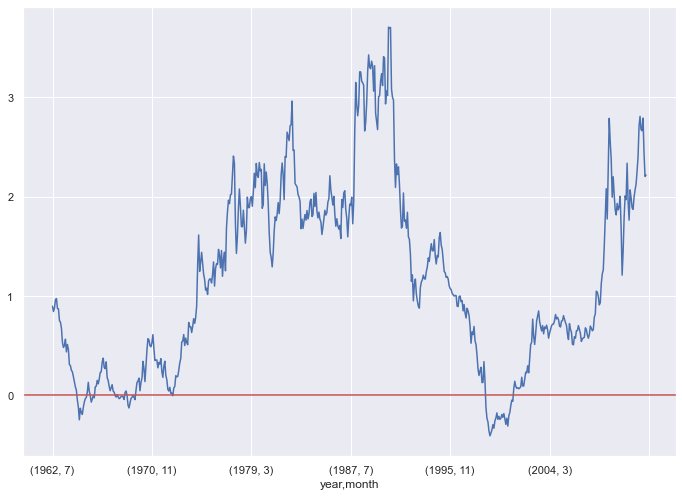

In [168]:
tens = df_years[10].dropna()
tens.plot()
plt.axhline(0,c='r');


In [170]:
tens.sort_values().iloc[:50]

year  month
1999  3       -0.406386
      4       -0.379751
      2       -0.354600
      5       -0.346298
      7       -0.330288
2000  9       -0.308596
1999  6       -0.293969
2000  7       -0.291414
1999  1       -0.265191
      8       -0.256819
1964  10      -0.245189
2000  1       -0.241041
1999  11      -0.239734
2000  6       -0.233134
      8       -0.230097
      2       -0.229903
1998  12      -0.229790
1999  9       -0.227043
2000  4       -0.219641
1999  12      -0.211158
2000  10      -0.205575
      3       -0.191691
1965  1       -0.191032
2000  5       -0.182962
1999  10      -0.175901
2000  11      -0.172198
1964  12      -0.171168
      11      -0.129154
1968  12      -0.126142
1965  2       -0.120831
1964  9       -0.118294
1998  11      -0.118252
2000  12      -0.102209
1968  11      -0.099217
1969  1       -0.074620
1965  10      -0.067697
      3       -0.066796
2001  2       -0.058484
      1       -0.047445
1964  8       -0.046526
1969  6       -0.042335
1968

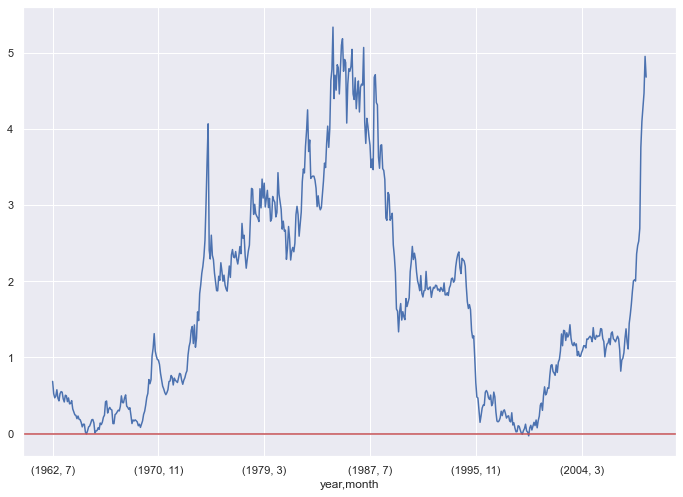

In [166]:
df_years[13].dropna().plot()
plt.axhline(0,c='r')

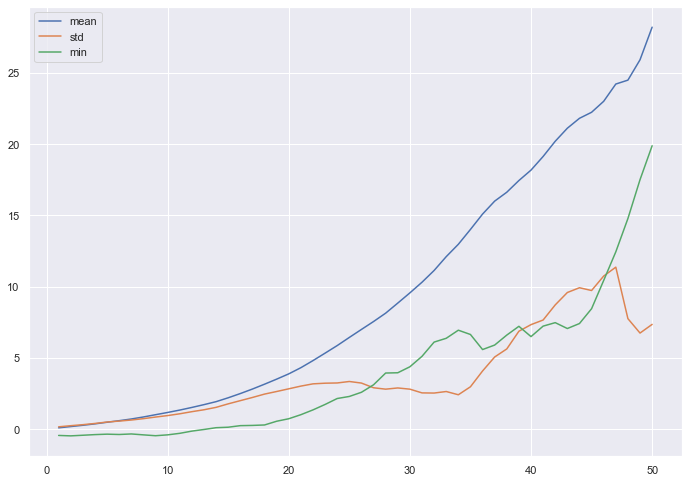

In [148]:
stats = df_years.describe()
stats.loc['mean'].plot()
stats.loc['std'].plot()
stats.loc['min'].plot()
plt.legend()